Instalación

In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import os

# Descarga el dataset (o usa el caché)
romanniki_food_delivery_cost_and_profitability_path = kagglehub.dataset_download('romanniki/food-delivery-cost-and-profitability')

# Buscar el primer archivo dentro del dataset descargado
for root, dirs, files in os.walk(romanniki_food_delivery_cost_and_profitability_path):
    for file in files:
        path_dataset = os.path.abspath(os.path.join(root, file))
        break  # solo el primero
    else:
        continue
    break

print('Data source import complete.')
print("Archivo encontrado en:", path_dataset)

Data source import complete.
Archivo encontrado en: /home/jovyan/.cache/kagglehub/datasets/romanniki/food-delivery-cost-and-profitability/versions/1/food_orders_new_delhi (1).csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

EDA

In [4]:
df = pd.read_csv(path_dataset)
df.shape

(1000, 12)

In [5]:

# Convertir fechas a tipo datetime
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])

# Crear columna de tiempo de entrega en minutos
df['Delivery Duration (min)'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60
# Extraer día y hora del pedido
df['day_of_week'] = df['Order Date and Time'].dt.day_name()
df['hour_of_day'] = df['Order Date and Time'].dt.hour
# Marcar si hay descuento o no
df['has_discount'] = df['Discounts and Offers'].str.lower() != 'none'

# Marcar si fue reembolsado
df['refunded'] = df['Refunds/Chargebacks'] > 0
df

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Delivery Duration (min),day_of_week,hour_of_day,has_discount,refunded
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,88.0,Thursday,1,True,False
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,35.0,Friday,22,True,False
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,58.0,Wednesday,5,True,False
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0,46.0,Tuesday,22,False,False
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,89.0,Monday,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,C6232,R2129,2024-01-14 05:57:00,2024-01-14 06:39:00,825,0,Digital Wallet,5% on App,165,47,50,42.0,Sunday,5,True,True
996,997,C6797,R2742,2024-01-28 08:50:43,2024-01-28 10:10:43,1627,50,Cash on Delivery,None,110,42,0,80.0,Sunday,8,False,False
997,998,C5926,R2837,2024-01-21 09:43:19,2024-01-21 10:44:19,553,20,Cash on Delivery,None,64,31,0,61.0,Sunday,9,False,False
998,999,C7016,R2144,2024-01-30 22:23:38,2024-01-31 00:07:38,1414,0,Cash on Delivery,15% New User,199,34,0,104.0,Tuesday,22,True,False


In [6]:
print(df['Discounts and Offers'].value_counts())

10%             233
50 off Promo    201
15% New User    198
None            185
5% on App       183
Name: Discounts and Offers, dtype: int64


In [7]:
def calcular_descuento(row):
    valor = str(row['Discounts and Offers']).lower()
    pedido = row['Order Value']
    
    # Si es porcentaje, por ejemplo "10%" o "5% on app"
    if '%' in valor:
        try:
            porcentaje = float(valor.split('%')[0])
            return pedido * (porcentaje / 100)
        except:
            return 0
        
    # Si es "50 off Promo" u otros con valor fijo
    elif 'off' in valor:
        for token in valor.split():
            try:
                return float(token)
            except:
                continue
        return 0

    # Si es "None" u otra cosa no reconocida
    return 0

# Aplicar al DataFrame
df['Discount Value'] = df.apply(calcular_descuento, axis=1)

# Verificar
df[['Discounts and Offers', 'Order Value', 'Discount Value']].head(10)

,Discounts and Offers,Order Value,Discount Value
0,5% on App,1914,95.70
1,10%,986,98.60
2,15% New User,937,140.55
3,None,1463,0.00
4,50 off Promo,1992,50.00
5,10%,439,43.90
6,5% on App,303,15.15
7,10%,260,26.00
8,5% on App,1663,83.15
9,10%,491,49.10


In [8]:
df['Total Cost'] = df['Delivery Fee'] + df['Discount Value'] + df['Payment Processing Fee'] + df['Refunds/Chargebacks']

In [9]:
df['Profit'] = df['Commission Fee'] - df['Total Cost']

# Estadísticas generales
print("Ganancia media por pedido:", round(df['Profit'].mean(), 2))
print("Pedidos con pérdida:", (df['Profit'] < 0).sum())
print("Porcentaje con pérdida:", round((df['Profit'] < 0).mean() * 100, 2), '%')

Ganancia media por pedido: -34.05
Pedidos con pérdida: 579
Porcentaje con pérdida: 57.9 %


In [10]:
# Mostrar los 10 pedidos con mayores pérdidas (menor Profit)
top_losses = df.sort_values(by='Profit').tail(10)

# Mostrar solo las columnas clave para el análisis
top_losses[[ 'Order Value', 'Commission Fee', 'Total Cost', 'Profit', 'Discounts and Offers']]

,Order Value,Commission Fee,Total Cost,Profit,Discounts and Offers
151,956,188,54.00,134.00,None
780,990,198,64.00,134.00,50 off Promo
596,203,198,63.00,135.00,None
742,1786,197,61.00,136.00,None
480,1402,198,60.00,138.00,None
857,125,193,52.25,140.75,5% on App
684,204,195,51.00,144.00,None
898,1173,198,42.00,156.00,None
248,1857,190,33.00,157.00,None
14,1193,192,16.00,176.00,None


In [11]:
print(df)

     Order ID Customer ID Restaurant ID Order Date and Time  \
0           1       C8270         R2924 2024-02-01 01:11:52   
1           2       C1860         R2054 2024-02-02 22:11:04   
2           3       C6390         R2870 2024-01-31 05:54:35   
3           4       C6191         R2642 2024-01-16 22:52:49   
4           5       C6734         R2799 2024-01-29 01:19:30   
..        ...         ...           ...                 ...   
995       996       C6232         R2129 2024-01-14 05:57:00   
996       997       C6797         R2742 2024-01-28 08:50:43   
997       998       C5926         R2837 2024-01-21 09:43:19   
998       999       C7016         R2144 2024-01-30 22:23:38   
999      1000       C4335         R2890 2024-01-08 14:46:43   

    Delivery Date and Time  Order Value  Delivery Fee    Payment Method  \
0      2024-02-01 02:39:52         1914             0       Credit Card   
1      2024-02-02 22:46:04          986            40    Digital Wallet   
2      2024-01-31 

GRAFICOS


<AxesSubplot:>

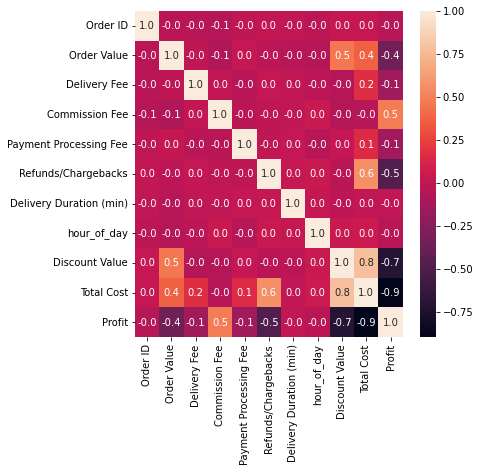

In [12]:
plt.figure(figsize=(6,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, fmt='.1f')

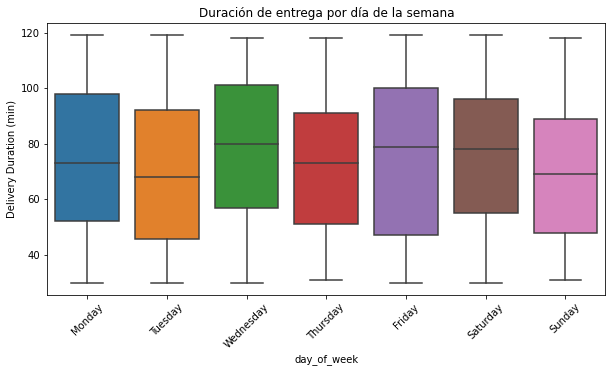

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='day_of_week', y='Delivery Duration (min)', 
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation=45)
plt.title("Duración de entrega por día de la semana")
plt.show()

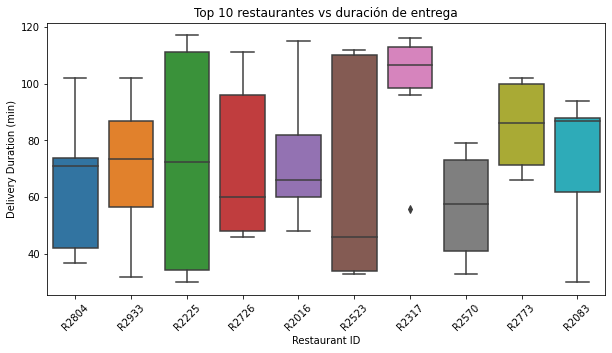

In [14]:
top_restaurants = df['Restaurant ID'].value_counts().nlargest(10).index

plt.figure(figsize=(10,5))
sns.boxplot(data=df[df['Restaurant ID'].isin(top_restaurants)],
            x='Restaurant ID', y='Delivery Duration (min)')
plt.xticks(rotation=45)
plt.title("Top 10 restaurantes vs duración de entrega")
plt.show()

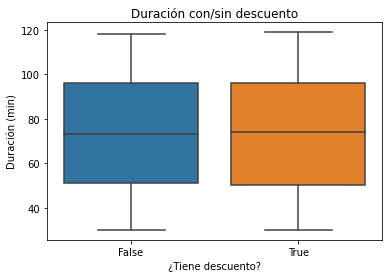

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='has_discount', y='Delivery Duration (min)')
plt.title("Duración con/sin descuento")
plt.xlabel("¿Tiene descuento?")
plt.ylabel("Duración (min)")
plt.show()

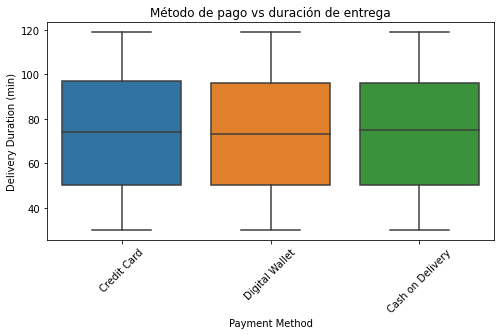

In [16]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='Payment Method', y='Delivery Duration (min)')
plt.title("Método de pago vs duración de entrega")
plt.xticks(rotation=45)
plt.show()

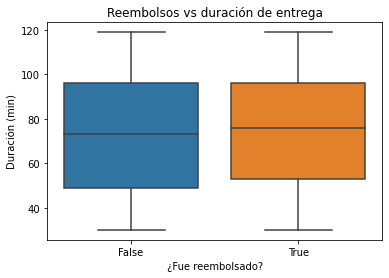

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='refunded', y='Delivery Duration (min)')
plt.title("Reembolsos vs duración de entrega")
plt.xlabel("¿Fue reembolsado?")
plt.ylabel("Duración (min)")
plt.show()

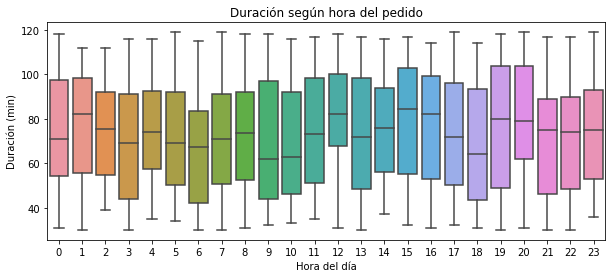

In [18]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x='hour_of_day', y='Delivery Duration (min)')
plt.title("Duración según hora del pedido")
plt.xlabel("Hora del día")
plt.ylabel("Duración (min)")
plt.show()

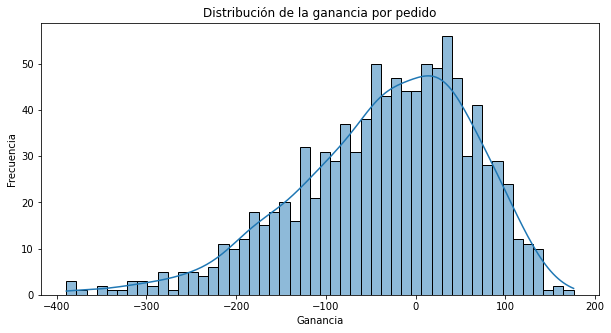

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['Profit'], bins=50, kde=True)
plt.title("Distribución de la ganancia por pedido")
plt.xlabel("Ganancia")
plt.ylabel("Frecuencia")
plt.show()

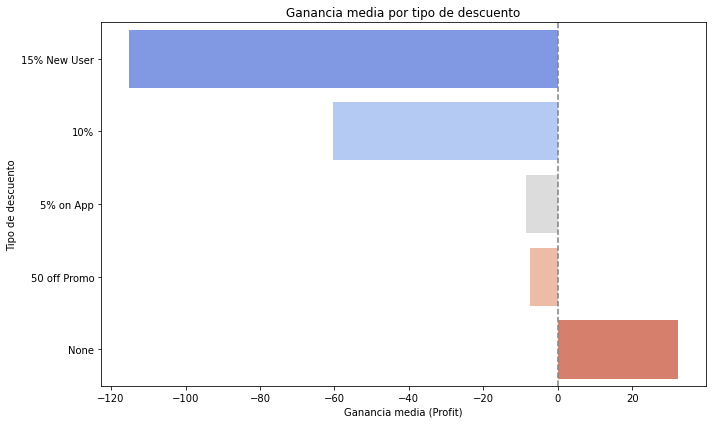

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarnos de que la columna tenga un nombre limpio (por si no lo hiciste antes)
df['Discounts and Offers'] = df['Discounts and Offers'].astype(str)

# Agrupar por tipo de descuento y calcular profit promedio
profit_por_descuento = df.groupby('Discounts and Offers')['Profit'].mean().sort_values()

# Crear gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=profit_por_descuento.values, y=profit_por_descuento.index, palette='coolwarm')
plt.title("Ganancia media por tipo de descuento")
plt.xlabel("Ganancia media (Profit)")
plt.ylabel("Tipo de descuento")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

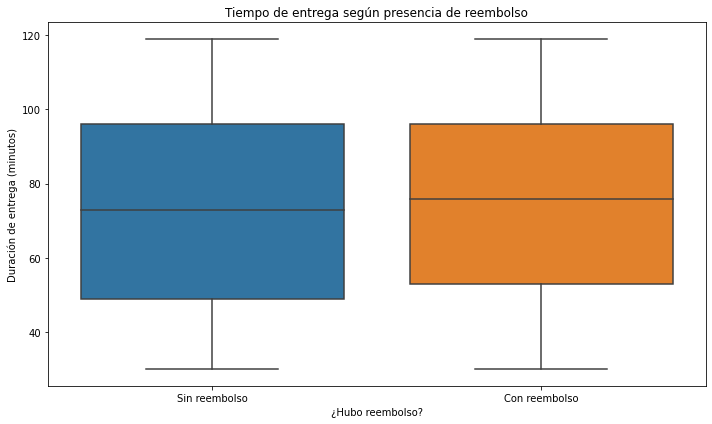

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que la columna de duración esté creada
if 'Delivery Duration (min)' not in df.columns:
    df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
    df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])
    df['Delivery Duration (min)'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60

# Crear columna binaria: ¿Hubo reembolso?
df['Refunded'] = df['Refunds/Chargebacks'] > 0

# Gráfico de distribución del tiempo de entrega según haya o no reembolso
plt.figure(figsize=(10,6))
sns.boxplot(x='Refunded', y='Delivery Duration (min)', data=df)
plt.xticks([0,1], ['Sin reembolso', 'Con reembolso'])
plt.title("Tiempo de entrega según presencia de reembolso")
plt.ylabel("Duración de entrega (minutos)")
plt.xlabel("¿Hubo reembolso?")
plt.tight_layout()
plt.show()

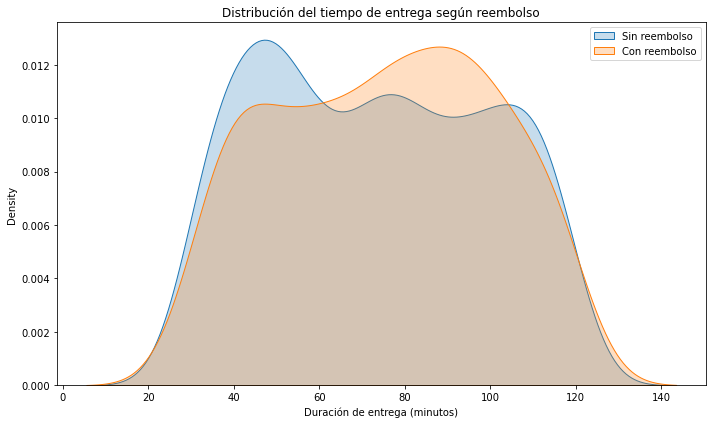

In [22]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['Refunded'] == False]['Delivery Duration (min)'], label='Sin reembolso', shade=True)
sns.kdeplot(df[df['Refunded'] == True]['Delivery Duration (min)'], label='Con reembolso', shade=True)
plt.title("Distribución del tiempo de entrega según reembolso")
plt.xlabel("Duración de entrega (minutos)")
plt.legend()
plt.tight_layout()
plt.show()

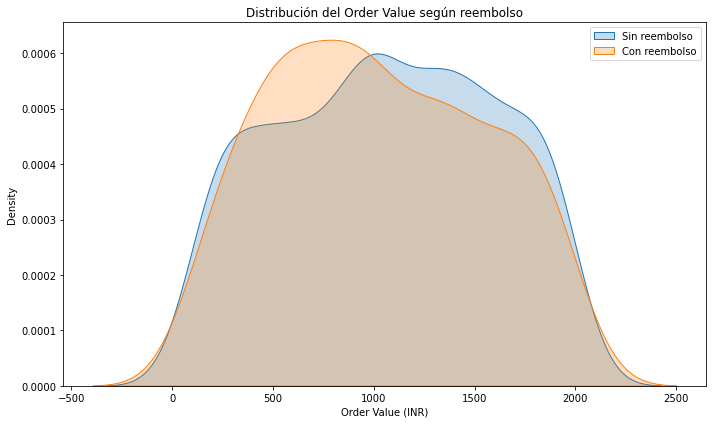

In [23]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['Refunded'] == False]['Order Value'], label='Sin reembolso', shade=True)
sns.kdeplot(df[df['Refunded'] == True]['Order Value'], label='Con reembolso', shade=True)
plt.title("Distribución del Order Value según reembolso")
plt.xlabel("Order Value (INR)")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Normalizar columnas en pandas
df.columns = df.columns.str.lower().str.replace(' ', '_')
# Eliminar espacios y duplicados en nombres de columnas
df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)

In [25]:
print (df)

     order_id customer_id restaurant_id order_date_and_time  \
0           1       C8270         R2924 2024-02-01 01:11:52   
1           2       C1860         R2054 2024-02-02 22:11:04   
2           3       C6390         R2870 2024-01-31 05:54:35   
3           4       C6191         R2642 2024-01-16 22:52:49   
4           5       C6734         R2799 2024-01-29 01:19:30   
..        ...         ...           ...                 ...   
995       996       C6232         R2129 2024-01-14 05:57:00   
996       997       C6797         R2742 2024-01-28 08:50:43   
997       998       C5926         R2837 2024-01-21 09:43:19   
998       999       C7016         R2144 2024-01-30 22:23:38   
999      1000       C4335         R2890 2024-01-08 14:46:43   

    delivery_date_and_time  order_value  delivery_fee    payment_method  \
0      2024-02-01 02:39:52         1914             0       Credit Card   
1      2024-02-02 22:46:04          986            40    Digital Wallet   
2      2024-01-31 

In [26]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Cerrar contexto anterior si está activo
if SparkContext._active_spark_context:
    SparkContext._active_spark_context.stop()

# SparkSession apuntando al cluster
spark = (
    SparkSession.builder.appName("DeliveryDurationGBT-Tuned-Light")
    .master("spark://agile:7077")
    .config("spark.driver.bindAddress", "0.0.0.0")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Añadir columnas derivadas en pandas antes de pasar a Spark
df["es_fin_de_semana"] = df["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)
df["es_hora_punta"] = df["hour_of_day"].between(13, 15) | df["hour_of_day"].between(20, 22)
df["es_hora_punta"] = df["es_hora_punta"].astype(int)

# Crear DataFrame en Spark
df_spark = spark.createDataFrame(df)

# Variables
categorical_cols = ['payment_method', 'discounts_and_offers', 'day_of_week', 'hour_of_day']
numeric_cols = [
    'order_value', 'delivery_fee', 'commission_fee', 'payment_processing_fee',
    'refunds/chargebacks', 'discount_value', 'has_discount', 'refunded',
    'es_fin_de_semana', 'es_hora_punta'
]
target = 'delivery_duration_(min)'

# Indexado y one-hot
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in categorical_cols]

# Vector de features
assembler = VectorAssembler(
    inputCols=numeric_cols + [col + "_vec" for col in categorical_cols],
    outputCol="features"
)

# Modelo
regressor = GBTRegressor(featuresCol="features", labelCol=target)

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, regressor])

# Grid de hiperparámetros ligera
paramGrid = ParamGridBuilder() \
    .addGrid(regressor.maxDepth, [5]) \
    .addGrid(regressor.maxIter, [20, 40]) \
    .build()

# Train-validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)

# Split de datos
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Entrenamiento
# tvs_model = tvs.fit(train_data)
tvs_model = pipeline.fit(train_data)

# Evaluación
predictions = tvs_model.transform(test_data)
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(predictions)

print("✅ Modelo mejorado con TrainValidationSplit")
print(f"📉 RMSE final: {rmse:.2f}")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 15:36:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Modelo mejorado con TrainValidationSplit
📉 RMSE final: 32.99


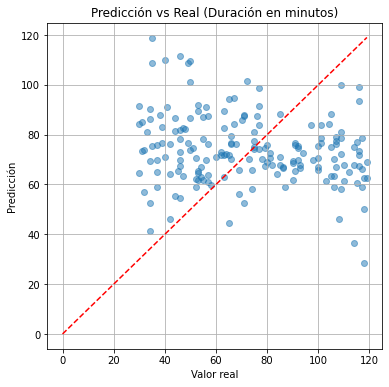

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertimos a Pandas para visualización
preds_pd = predictions.select("delivery_duration_(min)", "prediction").toPandas()

# Plot real vs predicho
plt.figure(figsize=(6,6))
plt.scatter(preds_pd["delivery_duration_(min)"], preds_pd["prediction"], alpha=0.5)
plt.plot([0, preds_pd.max().max()], [0, preds_pd.max().max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real (Duración en minutos)")
plt.grid(True)
plt.show()

In [28]:
# Mostrar predicciones reales vs. predichas
predictions.select('delivery_duration_(min)', 'prediction').show(10)

+-----------------------+-----------------+
|delivery_duration_(min)|       prediction|
+-----------------------+-----------------+
|                   58.0|59.76082828530326|
|                   53.0|65.53867440988391|
|                  114.0| 74.9488632985992|
|                  100.0|66.88452785590404|
|                   50.0|101.1379954650942|
|                   98.0|69.67426253032023|
|      66.00000000000001| 76.4174852018139|
|      33.00000000000001|81.19250306420832|
|      66.00000000000001|76.62536639154865|
|                   86.0|66.71454503266844|
+-----------------------+-----------------+
only showing top 10 rows

